In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, shapiro, kstest, probplot
from sklearn.ensemble import IsolationForest

sns.set(style="whitegrid")

In [2]:
df = pd.read_csv("../data/salaries.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57194 entries, 0 to 57193
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           57194 non-null  int64 
 1   experience_level    57194 non-null  object
 2   employment_type     57194 non-null  object
 3   job_title           57194 non-null  object
 4   salary              57194 non-null  int64 
 5   salary_currency     57194 non-null  object
 6   salary_in_usd       57194 non-null  int64 
 7   employee_residence  57194 non-null  object
 8   remote_ratio        57194 non-null  int64 
 9   company_location    57194 non-null  object
 10  company_size        57194 non-null  object
dtypes: int64(4), object(7)
memory usage: 4.8+ MB


In [5]:
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(29883)

In [8]:
df = df.drop_duplicates()
df.shape

(27311, 11)

In [9]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,27311.000000,2.731100e+04,27311.000000,27311.000000
mean,2023.717989,1.633512e+05,152807.917286,26.511296
std,0.603236,2.892565e+05,75863.899248,43.860317
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2024.000000,9.840000e+04,98290.000000,0.000000
50%,2024.000000,1.420000e+05,141340.000000,0.000000
75%,2024.000000,1.950000e+05,193300.000000,100.000000
max,2024.000000,3.040000e+07,800000.000000,100.000000


In [10]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,MI,FT,Developer,168276,USD,168276,US,0,US,M
1,2024,MI,FT,Developer,112184,USD,112184,US,0,US,M
2,2024,EN,FT,Developer,180000,USD,180000,US,0,US,M
3,2024,EN,FT,Developer,133500,USD,133500,US,0,US,M
4,2024,EN,FT,Developer,122000,USD,122000,US,0,US,M


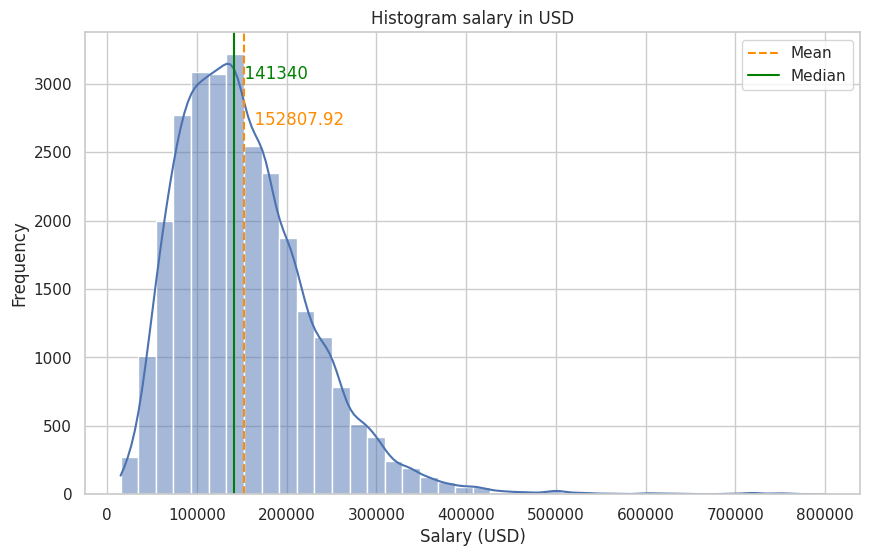

In [44]:
mean_salary = df["salary_in_usd"].mean()
median_salary = df["salary_in_usd"].median()

plt.figure(figsize=(10, 6))

sns.histplot(df["salary_in_usd"], bins=40, kde=True)

plt.axvline(mean_salary, color="darkorange", linestyle="--", label="Mean")
plt.text(mean_salary, plt.ylim()[1] * 0.8, f"  {mean_salary:.2f}", color="darkorange")

plt.axvline(median_salary, color="green", label="Median")
plt.text(median_salary, plt.ylim()[1] * 0.9, f"  {median_salary:.0f}", color="green")

plt.title("Histogram salary in USD")

plt.xlabel("Salary (USD)")
plt.ylabel("Frequency")

plt.legend()

plt.show()

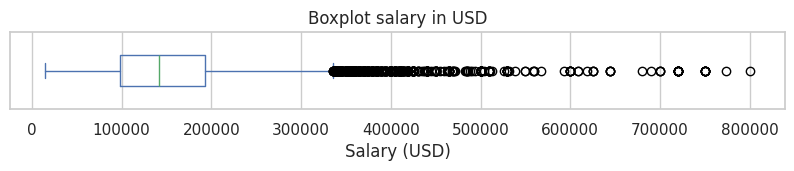

In [71]:
df["salary_in_usd"].plot.box(vert=False, widths=[0.4], figsize=(10, 1))

plt.title("Boxplot salary in USD")

plt.xlabel("Salary (USD)")
plt.yticks([])

plt.show()

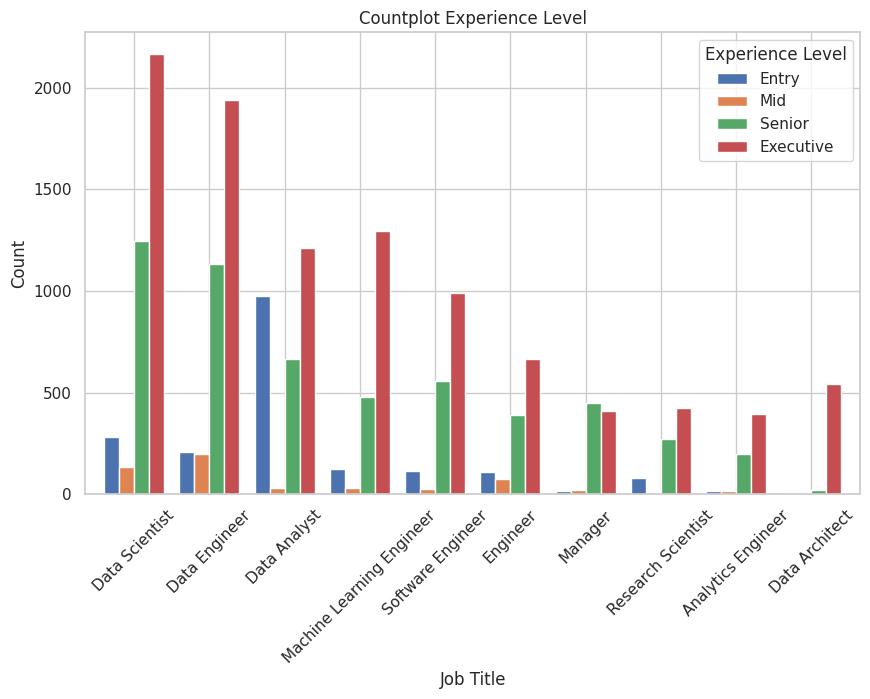

In [90]:
k_count = 10

counts = pd.crosstab(df["job_title"], df["experience_level"])
topk = counts.sum(axis=1).sort_values(ascending=False).head(k_count).index

counts.loc[topk].plot.bar(figsize=(10, 6), width=0.8)

plt.title("Countplot Experience Level")

plt.xlabel("Job Title")
plt.ylabel("Count")

plt.xticks(rotation=45)

plt.legend(["Entry", "Mid", "Senior", "Executive"], title="Experience Level")

plt.show()

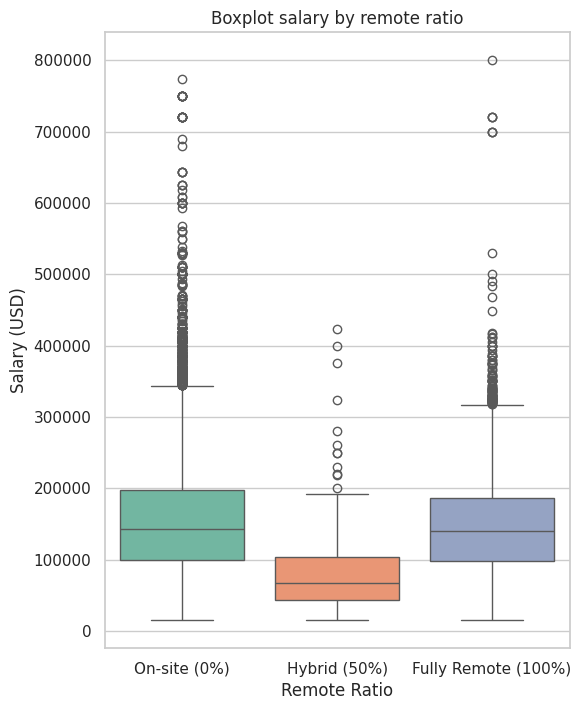

In [112]:
plt.figure(figsize=(6, 8))

sns.boxplot(data=df, x="remote_ratio", y="salary_in_usd", hue="remote_ratio", palette="Set2")

plt.title("Boxplot salary by remote ratio")

plt.xlabel("Remote Ratio")
plt.ylabel("Salary (USD)")

plt.xticks(range(3), ["On-site (0%)", "Hybrid (50%)", "Fully Remote (100%)"])

plt.legend().set_visible(False)

plt.show()